In [1]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
%matplotlib inline

In [2]:
fr_path = 'pretrained_models/DeepFreq/frequency_representation_module.pth'
fc_path = 'pretrained_models/DeepFreq/frequency_counting_module.pth'
data_dir = 'test_dataset'

### Use GPU or CPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fc_module, _, _, _, _ = util.load(fc_path, 'fc', device)
fr_module.cpu()
fr_module.eval()
fc_module.cpu()
fc_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [5]:
#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)

### Frequency estimation

In [6]:
idx = 8

In [7]:
with torch.no_grad():
    fr_0dB = fr_module(torch.tensor(signal_0dB[idx][None]))
    nestimate_0dB = fc_module(fr_0dB).numpy().round()
    fr_10dB = fr_module(torch.tensor(signal_10dB[idx][None]))
    nestimate_10dB = fc_module(fr_10dB).numpy().round()
    fr_50dB = fr_module(torch.tensor(signal_50dB[idx][None]))
    nestimate_50dB = fc_module(fr_50dB).numpy().round()
fr_0dB = fr_0dB.numpy()    
fr_10dB = fr_10dB.numpy()    
fr_50dB = fr_50dB.numpy()

Number of frequencies:

In [8]:
nfreq[idx]

9

Estimated number of frequencies 0dB/10dB/50dB:

In [9]:
nestimate_0dB[0, 0], nestimate_10dB[0, 0], nestimate_50dB[0, 0]

(8.0, 8.0, 9.0)

Compute frequency estimates:

In [10]:
f_estimate_0dB = fr.find_freq(fr_0dB, nestimate_0dB, xgrid)
f_estimate_10dB = fr.find_freq(fr_10dB, nestimate_10dB, xgrid)
f_estimate_50dB = fr.find_freq(fr_50dB, nestimate_50dB, xgrid)

### 50dB

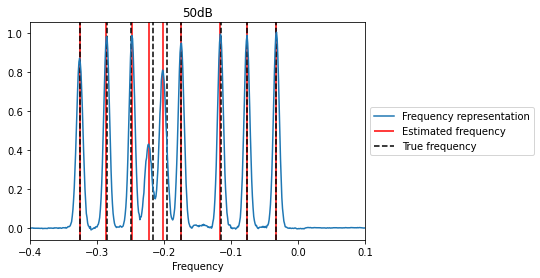

In [11]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_50dB[0], label='Frequency representation')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
f_model = f_estimate_50dB[f_estimate_50dB > -1]
ax.vlines(f_model, ymin=ylim[0], ymax=ylim[1], color='r', label='Estimated frequency')
ax.vlines(ff, linestyle='--', ymin=ylim[0], ymax=ylim[1], color='k', label='True frequency')
ax.set_ylim(ylim)
ax.set_xlim(-0.4, 0.1)
ax.set_xlabel('Frequency')
ax.set_title('50dB')
ax.legend( loc='center left', bbox_to_anchor=(1, 0.5))

### 10dB

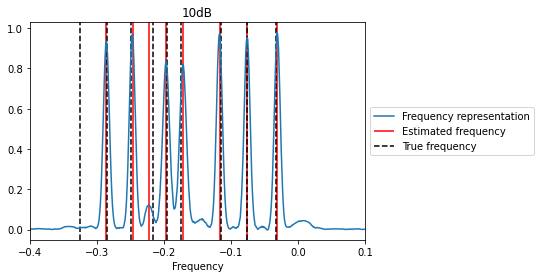

In [12]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_10dB[0], label='Frequency representation')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
f_model = f_estimate_10dB[f_estimate_10dB > -1]
ax.vlines(f_model, ymin=ylim[0], ymax=ylim[1], color='r', label='Estimated frequency')
ax.vlines(ff, linestyle='--', ymin=ylim[0], ymax=ylim[1], color='k', label='True frequency')
ax.set_ylim(ylim)
ax.set_xlim(-0.4, 0.1)
ax.set_xlabel('Frequency')
ax.set_title('10dB')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### 0dB

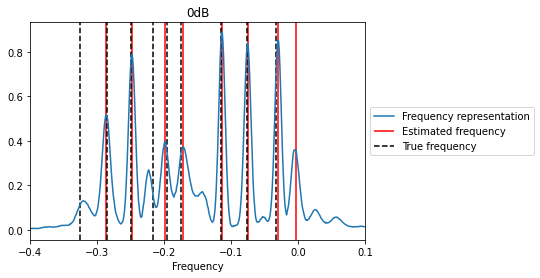

In [13]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_0dB[0], label='Frequency representation')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
f_model = f_estimate_0dB[f_estimate_0dB > -1]
ax.vlines(f_model, ymin=ylim[0], ymax=ylim[1], color='r', label='Estimated frequency')
ax.vlines(ff, linestyle='--', ymin=ylim[0], ymax=ylim[1], color='k', label='True frequency')
ax.set_ylim(ylim)
ax.set_xlim(-0.4, 0.1)
ax.set_xlabel('Frequency')
ax.set_title('0dB')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Impact of the noise

In [14]:
idx = 13
with torch.no_grad():
    fr_0dB = fr_module(torch.tensor(signal_0dB[idx][None])).numpy()[0]
    fr_10dB = fr_module(torch.tensor(signal_10dB[idx][None])).numpy()[0]
    fr_50dB = fr_module(torch.tensor(signal_50dB[idx][None])).numpy()[0]

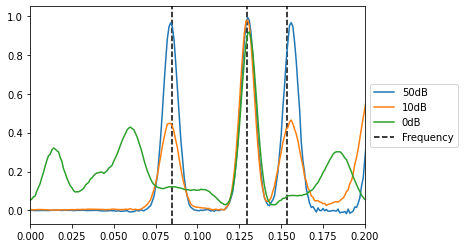

In [15]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_50dB, label='50dB')
ax.plot(xgrid, fr_10dB, label='10dB')
ax.plot(xgrid, fr_0dB, label='0dB')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_xlim(0., 0.2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Compute Jacobian

In [16]:
signal_50dB[8].shape

(2, 50)

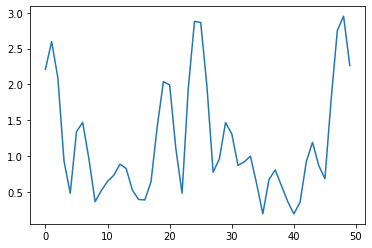

In [17]:
plt.plot(np.sqrt(signal_50dB[8, 0]**2 + signal_50dB[8, 1]**2))
plt.show()

In [18]:
fr_50dB = fr_module(torch.tensor(signal_50dB[idx][None]))

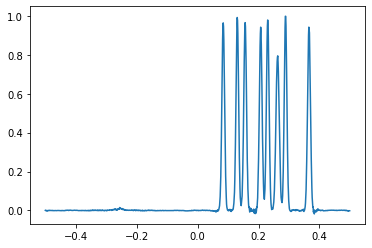

In [19]:
plt.plot(xgrid, fr_50dB[0].cpu().detach().numpy())
#plt.xlim(-0.4, 0.1)
plt.show()

In [20]:
inp = torch.tensor(signal_50dB[8][None])
inp.requires_grad = True
fr_50dB = fr_module(inp)
fr_50dB[0, 0].backward()
print(fr_50dB.shape)

torch.Size([1, 1000])


In [21]:
grad = []
for i in range(1000):
    inp = torch.tensor(signal_50dB[idx][None])
    inp.requires_grad = True
    fr_50dB = fr_module(inp)
    fr_50dB[0, i].backward()
    grad += [inp.grad.numpy()]

grad = np.vstack(grad)
grad = grad[:, 0] + 1j * grad[:, 1]

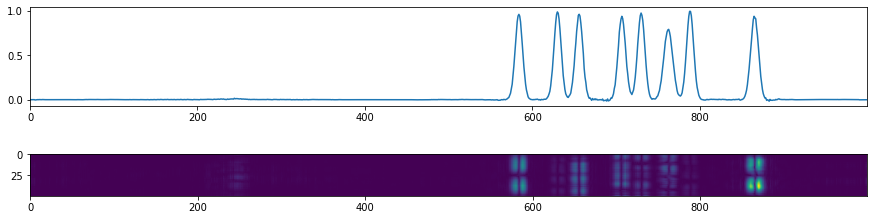

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].plot(xgrid, fr_50dB[0].cpu().detach().numpy())
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[1].imshow(np.abs(grad).T)
plt.show()